# Segmentation practice
This is a simple practice notebook for lung segmentation from CT scan slices. For the original idea and full tutorial see [Mr. P Solver's "Python Image Segmentation Tutorial (2022)"](https://youtu.be/UIgaLDgb2fY). The scan used in this practice is taken from [precision-medicine-toolbox](https://github.com/primakov/precision-medicine-toolbox) and processed by [dcm2npy](https://github.com/oakjt/simple-dcm2npy).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from scipy import ndimage as ndi
from scipy.ndimage import zoom
import plotly.graph_objects as go

In [2]:
scan_path = r"D:\Projs\datasets\CT\data_npy\LUNG1-001_20180209_CT.npy"
scan = np.load(scan_path)

### Truncating the input file
The irrelevant slices are removed, this includes everything below the lungs.

In [3]:
scan = scan[55:]

### Slice visualization
Visualization of one of the slices, the values represented in the 2D array correspond to Hounsfield units (HU).

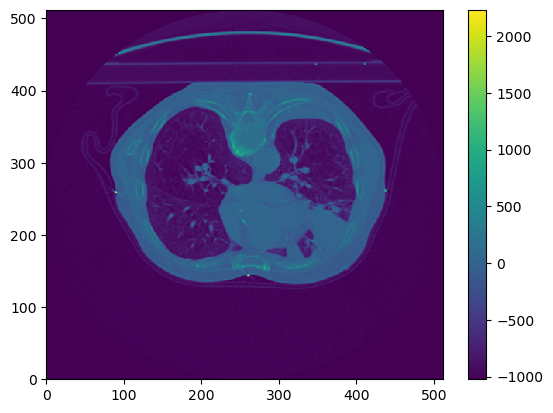

In [4]:
plt.pcolormesh(scan[50])
plt.colorbar()

### Scan info
This info is taken from the DICOM conversion process by dcm2npy. The slice thickness represents the size disparity in **Z** axis compared to **X** and **Y** axis. The window in this context refers to a HU range that is of interest in this particular problem. Here the window is \[-1200, 600\].

In [5]:
slice_thickness = 3
window_center = [40, -600]
window_width = [400, 1200]

In [6]:
window1_low = window_center[0] - window_width[0] / 2
air_mask = scan < window1_low

By visualizing a mask slice one can notice that the lung area is included in the mask. This is due to the lungs being filled with air which is a material corresponding to the previously defined window.

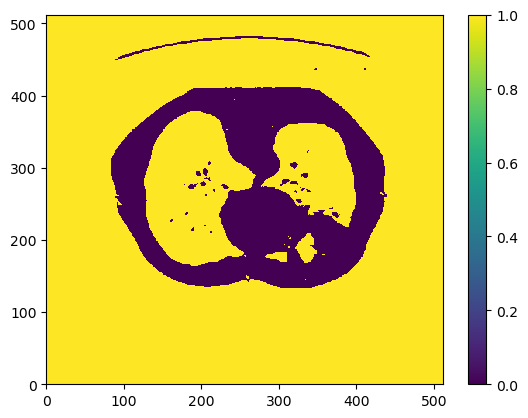

In [7]:
plt.pcolormesh(air_mask[50])
plt.colorbar()

Only the air inside the lungs is relevant, everything outside needs to be filtered out.

In [8]:
air_mask = np.vectorize(clear_border, signature="(n,m)->(n,m)")(air_mask)

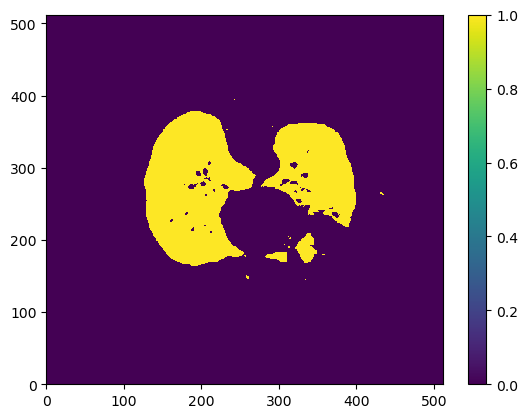

In [9]:
plt.pcolormesh(air_mask[50])
plt.colorbar()

### Fill
The initially selected area inside the lungs contains air, with this step other parts such as capillaries are also selected based on the surrounding area.

In [10]:
mask_filled = np.vectorize(ndi.binary_fill_holes, signature="(n,m)->(n,m)")(air_mask)

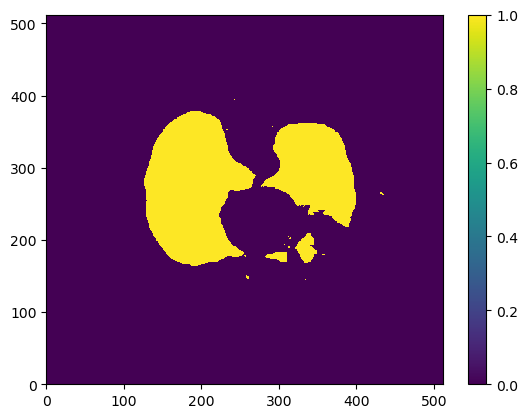

In [11]:
plt.pcolormesh(mask_filled[50])
plt.colorbar()

### Removing small non-connected regions
The small pockets are removed by filtering the regions with a smaller area than one defined by the user-selected function argument.

In [12]:
def remove_small(slc, low_area=25):
    new_slc = slc.copy()
    labels = label(new_slc, connectivity=1, background=0)
    rps = regionprops(labels)
    areas = np.array([r.area for r in rps])
    idxs = np.where(areas < low_area)[0]
    for i in idxs:
        new_slc[tuple(rps[i].coords.T)] = 0
    return new_slc

In [13]:
mask_no_small = np.vectorize(remove_small, signature="(n,m)->(n,m)")(mask_filled)

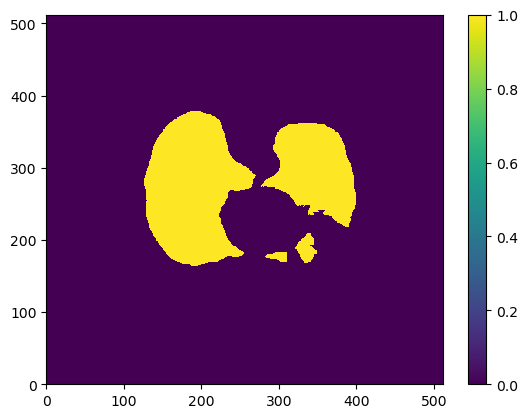

In [14]:
plt.pcolormesh(mask_no_small[50])
plt.colorbar()

### Resolution decrease
For easier rendering of the 3D volume the resolution of the entire array is lowered.

In [15]:
zoomed = zoom(1*(mask_no_small), (0.35, 0.35, 0.35))

In [16]:
zoomed.shape

(28, 179, 179)

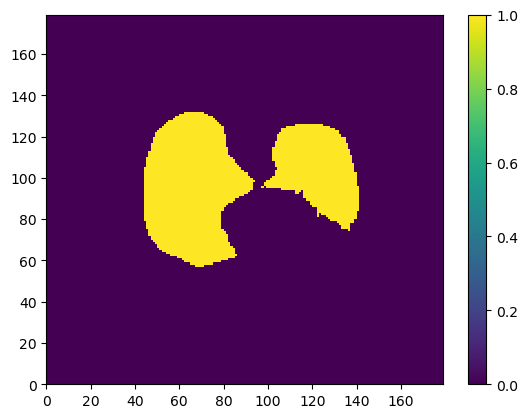

In [17]:
plt.pcolormesh(zoomed[20])
plt.colorbar()

### Z axis scale correction
Because of the difference in thickness the **Z** axis needs to be scaled with the factor provided in the DICOM file.

In [18]:
z, y, x = [np.arange(i) for i in zoomed.shape]
z *= int(slice_thickness)

In [19]:
X, Y, Z = np.meshgrid(x, y, z, indexing="ij")

### Rendering to interactive HTML
The segmented volume is written to an HTML file.

In [20]:
fig = go.Figure(data=go.Volume(
    x = X.flatten(),
    y = Y.flatten(),
    z = Z.flatten(),
    value = np.transpose(zoomed, (1, 2, 0)).flatten(),
    isomin = 0.1,
    opacity = 0.1,
    surface_count = 10,
    ))
fig.write_html("lungs.html")